# Fine-tuning with Tokenized Dataset
This notebook uses the tokenized_dataset approach where questions and answers are combined

In [1]:
import pandas as pd
import datasets
from pprint import pprint
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

/home/ivanppp/Training/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_NAME = "google/flan-t5-small"
FINETUNED_MODEL_DIR = "./ghana-finetuned-model-v2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
print(f"Loaded tokenizer: {MODEL_NAME}")

Loaded tokenizer: google/flan-t5-small


## Load and Tokenize Dataset
We'll load the Ghana Q&A data and tokenize it with questions and answers properly separated

In [3]:
def tokenize_function(examples):
    """Tokenize with proper input/label separation for Seq2Seq"""
    # Tokenize questions as inputs
    model_inputs = tokenizer(
        examples["question"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize answers as labels
    labels = tokenizer(
        examples["answer"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    # Replace padding token id with -100 so it's ignored in loss calculation
    labels["input_ids"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example]
        for labels_example in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Loading dataset...")
dataset = datasets.load_dataset("json", data_files="test/ghana_qa.json")
print(f"Dataset loaded: {len(dataset['train'])} examples")

print("\nTokenizing dataset...")
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset["train"].column_names)
print(f"Tokenization complete!")
print(f"\nDataset structure:")
print(tokenized_dataset)
print(f"\nSample data:")
print(f"Input IDs length: {len(tokenized_dataset['train'][0]['input_ids'])}")
print(f"Labels length: {len(tokenized_dataset['train'][0]['labels'])}")

Loading dataset...
Dataset loaded: 111 examples

Tokenizing dataset...
Dataset loaded: 111 examples

Tokenizing dataset...


Map: 100%|██████████| 111/111 [00:00<00:00, 3881.02 examples/s]

Tokenization complete!

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 111
    })
})

Sample data:
Input IDs length: 128
Labels length: 128


## Prepare Model with LoRA
Load the base model and configure it for efficient fine-tuning

In [4]:
from peft import LoraConfig, get_peft_model, TaskType

# Load the base model
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Configure LoRA
lora_config = LoraConfig(
    r=16,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["q", "v", "k", "o"],  # Which layers to apply LoRA to
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
print("\nModel prepared for fine-tuning!")

trainable params: 1,376,256 || all params: 78,337,408 || trainable%: 1.7568

Model prepared for fine-tuning!


## Train the Model
Configure training arguments and start fine-tuning using tokenized_dataset

In [5]:
import os
from transformers import TrainingArguments, Trainer, TrainerCallback

# Custom callback to track training metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.training_loss.append(logs['loss'])
            self.steps.append(state.global_step)

# Create output directory
os.makedirs(FINETUNED_MODEL_DIR, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=FINETUNED_MODEL_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-3,
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",
    remove_unused_columns=False,
)

# Create metrics callback
metrics_callback = MetricsCallback()

# Create trainer with tokenized_dataset
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],  # Using tokenized_dataset!
    tokenizer=tokenizer,
    callbacks=[metrics_callback],
)

print("Starting training with tokenized_dataset...")
print("=" * 50)
trainer.train()
print("=" * 50)
print("Training complete!")

# Store metrics for plotting
training_history = {
    'steps': metrics_callback.steps,
    'loss': metrics_callback.training_loss
}

/tmp/ipykernel_262081/3884136013.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.


Starting training with tokenized_dataset...


/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,4.590500
20,3.554900
30,2.637800
40,1.747900
50,0.944300
60,0.919100
70,1.014100
80,0.628000
90,0.708400
100,0.572800


/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3

Training complete!


## Visualize Training Performance

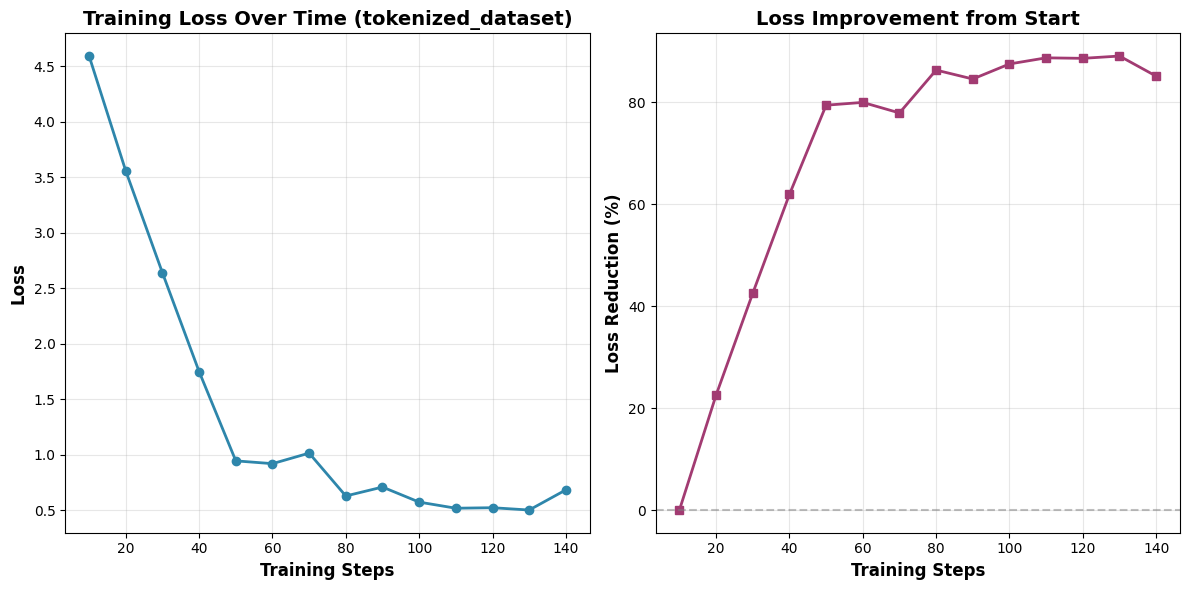


TRAINING PERFORMANCE SUMMARY (tokenized_dataset)
Initial Loss: 4.5905
Final Loss: 0.6828
Loss Reduction: 3.9077
Improvement: 85.1%
Total Training Steps: 140


In [6]:
import matplotlib.pyplot as plt

# Create figure with better styling
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_history['steps'], training_history['loss'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB')
plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss Over Time (tokenized_dataset)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Plot loss improvement
plt.subplot(1, 2, 2)
if len(training_history['loss']) > 0:
    initial_loss = training_history['loss'][0]
    loss_reduction = [(initial_loss - loss) / initial_loss * 100 
                      for loss in training_history['loss']]
    plt.plot(training_history['steps'], loss_reduction, 
             marker='s', linewidth=2, markersize=6, color='#A23B72')
    plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Loss Reduction (%)', fontsize=12, fontweight='bold')
    plt.title('Loss Improvement from Start', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('training_performance_tokenized.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "=" * 50)
print("TRAINING PERFORMANCE SUMMARY (tokenized_dataset)")
print("=" * 50)
print(f"Initial Loss: {training_history['loss'][0]:.4f}")
print(f"Final Loss: {training_history['loss'][-1]:.4f}")
print(f"Loss Reduction: {(training_history['loss'][0] - training_history['loss'][-1]):.4f}")
print(f"Improvement: {((training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100):.1f}%")
print(f"Total Training Steps: {training_history['steps'][-1]}")
print("=" * 50)

## Save the Model

In [7]:
# Save the model
model.save_pretrained(FINETUNED_MODEL_DIR)
tokenizer.save_pretrained(FINETUNED_MODEL_DIR)
print(f"Model saved to {FINETUNED_MODEL_DIR}")

Model saved to ./ghana-finetuned-model-v2


## Test the Fine-tuned Model
Compare original vs fine-tuned model performance

In [8]:
from peft import PeftModel
import torch

def test_models():
    """Test and compare both models"""
    print("=== TESTING ORIGINAL vs FINE-TUNED MODEL (tokenized_dataset) ===")
    print()
    
    # Load tokenizer and models
    test_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    original_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
    
    if os.path.exists(FINETUNED_MODEL_DIR):
        base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
        finetuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL_DIR)
        finetuned_model.eval()
    else:
        print("Fine-tuned model not found!")
        return
    
    # Test questions
    test_questions = [
        "When did Ghana gain independence?",
        "What is the capital of Ghana?",
        "Where is Ghana located?",
        "Who colonized Ghana?",
        "What was Ghana formerly called?"
    ]
    
    correct_original = 0
    correct_finetuned = 0
    
    for question in test_questions:
        print(f"\nQuestion: {question}")
        
        # Test original model
        inputs = test_tokenizer(question, return_tensors="pt")
        with torch.no_grad():
            outputs_orig = original_model.generate(**inputs, max_length=50)
            original_answer = test_tokenizer.decode(outputs_orig[0], skip_special_tokens=True)
        
        # Test fine-tuned model
        with torch.no_grad():
            outputs_ft = finetuned_model.generate(**inputs, max_length=50)
            finetuned_answer = test_tokenizer.decode(outputs_ft[0], skip_special_tokens=True)
        
        print(f"  Original Model: {original_answer}")
        print(f"  Fine-tuned Model: {finetuned_answer}")
        
        # Check correctness
        expected_answers = {
            "When did Ghana gain independence?": ["1957", "March 6"],
            "What is the capital of Ghana?": ["Accra"],
            "Where is Ghana located?": ["West Africa", "Africa"],
            "Who colonized Ghana?": ["Britain", "British"],
            "What was Ghana formerly called?": ["Gold Coast"]
        }
        
        expected = expected_answers.get(question, [])
        if any(exp.lower() in original_answer.lower() for exp in expected):
            correct_original += 1
        if any(exp.lower() in finetuned_answer.lower() for exp in expected):
            correct_finetuned += 1
    
    print("\n" + "=" * 50)
    print(f"Original Model Accuracy: {correct_original}/{len(test_questions)} = {correct_original/len(test_questions)*100:.1f}%")
    print(f"Fine-tuned Model Accuracy: {correct_finetuned}/{len(test_questions)} = {correct_finetuned/len(test_questions)*100:.1f}%")
    print("=" * 50)

# Run the test
test_models()

=== TESTING ORIGINAL vs FINE-TUNED MODEL (tokenized_dataset) ===


Question: When did Ghana gain independence?

Question: When did Ghana gain independence?
  Original Model: 1897
  Fine-tuned Model: March 6, 1957, 1957, was 1957, and was a British colonial colonial period. Gold Coast was Britain's first colonial colonial period. Gold Coast was Britain's first colonial period.

Question: What is the capital of Ghana?
  Original Model: 1897
  Fine-tuned Model: March 6, 1957, 1957, was 1957, and was a British colonial colonial period. Gold Coast was Britain's first colonial colonial period. Gold Coast was Britain's first colonial period.

Question: What is the capital of Ghana?
  Original Model: nasa
  Fine-tuned Model: Accra, Accra, is Accra's capital, Accra. Accra is the capital of Ghana.

Question: Where is Ghana located?
  Original Model: nasa
  Fine-tuned Model: West Africa

Question: Who colonized Ghana?
  Original Model: nasa
  Fine-tuned Model: Accra, Accra, is Accra's capital, Ac